gen	nevals	avg                    	std                    	min                    	max                    
0  	50    	[0.76513648 0.19219001]	[0.15291492 0.15452497]	[0.         0.00207716]	[0.88227952 1.        ]
1  	50    	[0.84223976 0.08944016]	[0.01991982 0.06847417]	[0.79156657 0.00156868]	[0.88227952 0.24693182]
2  	50    	[0.84885046 0.06167788]	[0.01869629 0.06544001]	[0.79547678 0.00125937]	[0.88227952 0.2278786 ]
3  	50    	[0.85607349 0.06048945]	[0.01257756 0.05865419]	[0.7991976  0.00125937]	[0.88227952 0.18823696]
4  	50    	[0.86035438 0.06476975]	[0.00969171 0.06050484]	[0.84658871 0.00116083]	[0.88227952 0.1881851 ]
5  	50    	[0.86190089 0.06118296]	[0.01080411 0.06245723]	[0.8475548  0.00108067]	[0.89186352 0.17964013]
6  	50    	[0.86112241 0.05509526]	[0.0111764  0.06588907]	[0.84744096 0.00108067]	[0.89186352 0.17964013]
7  	50    	[0.86236665 0.0580341 ]	[0.01071942 0.06615156]	[0.84744096 0.00108067]	[0.89186352 0.18525642]
8  	50    	[0.86028682 0.03870206]	[0

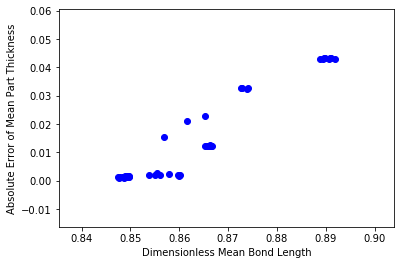

Wall time: 1min 30s


In [8]:
%%time
#    This file is part of DEAP.
#
#    DEAP is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    DEAP is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import array
import logging
import random
import numpy as np

# imports for the BNN
import torch
import torch.nn as nn
import torch.nn.functional as F

import keras
from keras import backend as K

import pickle

from deap import algorithms, base, benchmarks, creator, tools


# load min and max values of the data to denormalize prediction data
with open('maxmin.pickle', 'rb') as f:
    [max_x, min_x, max_y, min_y] = pickle.load(f)
    
# load min and max values of the data to denormalize prediction data
with open('maxmin_thickness.pickle', 'rb') as f:
    [X_max, X_min, Y_max, Y_min] = pickle.load(f)    

def normalize_max_min(data, data_max, data_min):
    return (data-data_min) / (data_max-data_min)

def denormalize_max_min(data, data_max, data_min):
    return data * (data_max-data_min) + data_min

class KerasDropoutPrediction(object):
    def __init__(self,model):
        self.f = K.function(
                [model.layers[0].input, 
                 K.learning_phase()],
                [model.layers[-1].output])
        
    def predict(self, x, n_iter=10):
        result = []
        for _ in range(n_iter):
            result.append(self.f([x, 1]))
        result = np.array(result).reshape(n_iter,len(x)).T
        return result
    
class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob

        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2 * output_dim)

        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.view(-1, self.input_dim)

        x = self.layer1(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer2(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer3(x)

        return x

def evaluate(vars):

    max_part_height = 4.2   # maximum part height mm

    # number of total layers = (maximum part height)/(height of a layer), i.e., 4.2 / (layer height)
    if vars[2] == 1:
        height = 0.42
    elif vars[2] == 2:
        height = 0.6
    elif vars[2] == 3:
        height = 0.7

    # print(vars)
    num_layers = np.int(max_part_height / height); # number of layers

    num_interfaces = 14     # number of interfaces per layer
    width = 0.8             # filament width in mm

    ycoord = 0.5 * height  # 0.5*height of a layer in mm
    iki_y = ycoord * 2
    
    # Create an input array to predict overall part thickness
    inp_BL = [] # input to BNN to make predictions
    
    # store inputs for GP(model disrepancy at each interface)
    for jj in range(1, num_layers + 1):
        for ii in range(1, num_interfaces + 1):
            # use x & y coordinates of vertical bonds as training data for the GP
            # Inp =[ Temperature, speed, height, x, y ]
            inp_BL.append([vars[0], vars[1], height, ii * width, ycoord + (jj - 1) * iki_y])

    # Convert built Python lists to a Numpy array.
    inp_BL = np.array(inp_BL, dtype='float32')

    # normalize data
    inp_BL = normalize_max_min(inp_BL, max_x, min_x)

    x_pred = torch.tensor(inp_BL)  # convert to torch tensor

    samples = []
    noises = []
    for i in range(10):
        preds = toolbox.model1.forward(x_pred).cpu().data.numpy()
        samples.append(denormalize_max_min(preds[:, 0], max_y, min_y))
        noises.append(denormalize_max_min(np.exp(preds[:, 1]), max_y, min_y))

    samples, noises = np.array(samples),  np.array(noises)
    means = (samples.mean(axis=0)).reshape(-1)

    aleatoric = (noises ** 2).mean(axis=0) ** 0.5
    epistemic = (samples.var(axis=0) ** 0.5).reshape(-1)
    total_unc = (aleatoric ** 2 + epistemic ** 2) ** 0.5


    # Dimensionless BL: non-dimensionalize the BL by dividing with the layer height
    dimensionless_mean_bl = means.mean()/height
    dimensionless_total_unc_bl = total_unc.mean()/height**2

    x_pos = 7 # mm
    num_iter = (10.5-1.5)/0.01 + 1
        
     # Create an input array to predict overall part thickness
    inp_thickness = []
    
    # store inputs for GP(model disrepancy at each interface)
    for jj in range(5):

        y_pos = 1.5 # mm

        for ii in range(int(num_iter)):
            # use x & y coordinates of vertical bonds as training data for the GP
            # Inp =[ Temperature, speed, height, x, y]
            inp_thickness.append([vars[0], vars[1], height, x_pos, y_pos])
            
            y_pos += 0.01 # increment y position 0.01 mm

        x_pos += 5 # x coordinate  
    
    # Convert built Python lists to a Numpy array.
    inp_thickness = np.array(inp_thickness, dtype='float32')

    # normalize data
    inp_thickness = normalize_max_min(inp_thickness, X_max, X_min)
    
    # Predict
    y_pred_do = toolbox.model2.predict(inp_thickness,n_iter=5)
    y_pred_do_org = denormalize_max_min(y_pred_do, Y_max, Y_min)
    y_pred_do_org_mean = y_pred_do_org.mean(axis=1).reshape(-1, 1)
    y_pred_do_org_std = y_pred_do_org.std(axis=1).reshape(-1, 1)
    
    # Predicted mean and std part thicknesses
    mean_part_thickness = y_pred_do_org_mean.mean()
    std_part_thickness = ((y_pred_do_org_std**2).mean())**0.5
    
    # Minimize(abs(pred_mean – target))
    target  = 4.2 # desired part thickness in mm
    
    return dimensionless_mean_bl, abs(mean_part_thickness-target)



# The constraint is:
# (Nozzle velocity) x (line width) x (layer thickness)  less than/ equal to 24 mm/s3
def feasible(individual):
    """Feasability function for the individual. Returns True if feasible False
    otherwise."""
    
    line_width = 0.8 # in mm
    
    # layer height in mm
    if individual[2] == 1:
        height = 0.42
    elif individual[2] == 2:
        height = 0.6
    elif individual[2] == 3:
        height = 0.7
        
    if individual[1] * line_width * height <= 24:
#         print(individual,'true')
        return True
#     print(individual,'false')
    return False

IND_SIZE = 3
N_CYCLES = 1
BOUND_LOW, BOUND_UP = [217, 26, 1], [278, 44, 3]

creator.create("FitnessMin", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin, n=IND_SIZE)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_temperature", random.randint, 217, 278)
toolbox.register("attr_speed", random.randint, 26, 44)
toolbox.register("attr_layer", random.randint, 1, 3)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_temperature,toolbox.attr_speed,toolbox.attr_layer), n=N_CYCLES)

# Structure initializers
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# load BL model BNN and evaluate objectives
toolbox.model1 = torch.load('BNN_BLmodel.pt')
toolbox.register("evaluate", evaluate)

# load the thickness model
model_thickness = keras.models.load_model('MCdropout_model_thickness.h5', compile=False)

# predict with dropout
toolbox.model2 = KerasDropoutPrediction(model_thickness)

# A penality function can be added to any evaluation function using the DeltaPenality decorator provided in the tools module.
# Delta = [0,1] worst cases
toolbox.decorate("evaluate", tools.DeltaPenality(feasible, [0,1]))

toolbox.register("mate", tools.cxUniform, indpb=0.50)
toolbox.register("mutate", tools.mutUniformInt, low=BOUND_LOW, up=BOUND_UP, indpb=0.50)

def checkBounds(min, max):
    def decorator(func):
        def wrappper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max[i]:
#                         print(child[i])
                        child[i] = max[i]
                    elif child[i] < min[i]:
#                         print(child[i])
                        child[i] = min[i]
            return offspring
        return wrappper
    return decorator

# Bounds on the design variables
toolbox.decorate("mate", checkBounds([217, 26, 1], [278, 44, 3]))
toolbox.decorate("mutate", checkBounds([217, 26, 1], [278, 44, 3]))

toolbox.register("select", tools.selNSGA2)
# ref_points = tools.uniform_reference_points(nobj=2, p=12)
# toolbox.register("select", tools.selNSGA3WithMemory(ref_points))

toolbox.pop_size = 50
toolbox.max_gen = 10
toolbox.mut_prob = 0.2

def main(toolbox):
    random.seed(64)

    pop = toolbox.population(n=toolbox.pop_size)
    hof = tools.ParetoFront()
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, lambda_=toolbox.pop_size,
                              cxpb=1-toolbox.mut_prob, mutpb=toolbox.mut_prob, ngen=toolbox.max_gen,
                              stats=stats, halloffame=hof, verbose=True)

    return pop, stats, hof


if __name__ == "__main__":
    pop, stats, hof = main(toolbox)

    import matplotlib.pyplot as plt
    import numpy

    front = numpy.array([ind.fitness.values for ind in pop])
    plt.scatter(front[:,0], front[:,1], c="b")
    plt.axis("tight")
    plt.xlabel("Dimensionless Mean Bond Length")
    plt.ylabel("Absolute Error of Mean Part Thickness")
    plt.show()


In [6]:
pop

[Individual('d', [264.0, 31.0, 1.0]),
 Individual('d', [217.0, 26.0, 1.0]),
 Individual('d', [270.0, 33.0, 1.0]),
 Individual('d', [264.0, 31.0, 1.0]),
 Individual('d', [264.0, 31.0, 1.0]),
 Individual('d', [217.0, 26.0, 1.0]),
 Individual('d', [264.0, 31.0, 1.0]),
 Individual('d', [270.0, 26.0, 2.0]),
 Individual('d', [270.0, 30.0, 2.0]),
 Individual('d', [269.0, 26.0, 2.0]),
 Individual('d', [270.0, 26.0, 2.0]),
 Individual('d', [269.0, 26.0, 2.0]),
 Individual('d', [270.0, 26.0, 2.0]),
 Individual('d', [269.0, 26.0, 2.0]),
 Individual('d', [270.0, 26.0, 2.0]),
 Individual('d', [270.0, 26.0, 2.0]),
 Individual('d', [270.0, 26.0, 2.0]),
 Individual('d', [269.0, 26.0, 2.0]),
 Individual('d', [264.0, 31.0, 1.0]),
 Individual('d', [220.0, 28.0, 1.0]),
 Individual('d', [264.0, 31.0, 1.0]),
 Individual('d', [220.0, 27.0, 1.0]),
 Individual('d', [220.0, 26.0, 1.0]),
 Individual('d', [220.0, 27.0, 1.0]),
 Individual('d', [220.0, 26.0, 1.0]),
 Individual('d', [220.0, 26.0, 1.0]),
 Individual(